Loaded shape: (256, 256, 3)
Tensor shape for SRM: torch.Size([1, 3, 256, 256])

After width padding:
tensor([[1.0000, 1.0000, 1.0000,  ..., 0.1804, 0.1725, 0.1804],
        [1.0000, 1.0000, 1.0000,  ..., 0.1765, 0.1725, 0.1765],
        [1.0000, 1.0000, 1.0000,  ..., 0.1725, 0.1686, 0.1725],
        ...,
        [0.0706, 0.0706, 0.0706,  ..., 0.1373, 0.1451, 0.1373],
        [0.0667, 0.0667, 0.0667,  ..., 0.1412, 0.1490, 0.1412],
        [0.0627, 0.0627, 0.0627,  ..., 0.1490, 0.1529, 0.1490]])
SRM output shape: torch.Size([1, 3, 256, 256])
IDX MISSING:  1
IDX MISSING:  128
IDX MISSING:  1
IDX MISSING:  128
SRM Output Shape: torch.Size([1, 3, 256, 256])

After width padding:
tensor([[1.0000, 1.0000, 1.0000,  ..., 0.1686, 0.1725, 0.1804],
        [1.0000, 1.0000, 1.0000,  ..., 0.1686, 0.1725, 0.1765],
        [1.0000, 1.0000, 1.0000,  ..., 0.1686, 0.1686, 0.1725],
        ...,
        [0.0706, 0.0706, 0.0706,  ..., 0.1451, 0.1451, 0.1373],
        [0.0667, 0.0667, 0.0667,  ..., 0.1529, 0

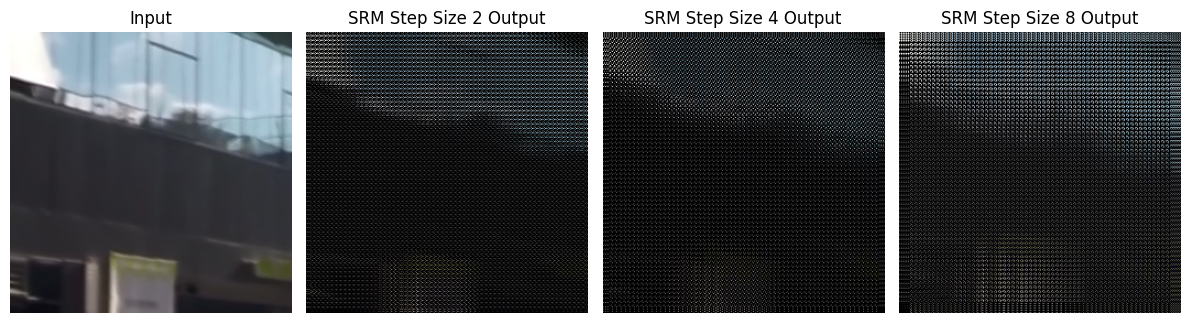

In [3]:
import os
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as T
from srm import SRMBlock
from linear_gating import LinearGating
from mssr import MSSRNetwork

torch.set_printoptions(linewidth=200)
# Load Input Blurry Image
load_dir = './Datasets/train/GoPro/input_crops'
name = '000002-5'
img_path = os.path.join(load_dir, name + '.png')

# Load full RGB image (H, W, 3)
input_img = plt.imread(img_path)
print("Loaded shape:", input_img.shape)  # Should be (256, 256, 3)

# Convert to tensor: (1, 3, H, W)
transform = T.Compose([
    T.ToTensor(),  # Converts to [0, 1], shape (C, H, W)
])

input_tensor = transform(input_img).unsqueeze(0)  # → shape: (1, 3, 256, 256)

print("Tensor shape for SRM:", input_tensor.shape)

srm_block = SRMBlock(window_size=4, step_size=2, in_channels=3, original_height=256, original_width=256)
output_s2 = srm_block(input_tensor)

print("SRM Output Shape:", output_s2.shape)

srm_block = SRMBlock(window_size=4, step_size=4, in_channels=3, original_height=256, original_width=256)
output_s4 = srm_block(input_tensor)

print("SRM Output Shape:", output_s4.shape)

srm_block = SRMBlock(window_size=4, step_size=8, in_channels=3, original_height=256, original_width=256)
output_s8 = srm_block(input_tensor)

print("SRM Output Shape:", output_s4.shape)

'''
# Initialize gating module with correct channel size
gating = LinearGating(dim=output.shape[1], use_activation=False)  # or True if you want sigmoid mask
# ADD THIS BLOCK right here to initialize to identity
with torch.no_grad():
    gating.fc.weight.copy_(torch.eye(3))
    gating.fc.bias.zero_()
'''

to_pil = T.ToPILImage()

# Remove batch dimension and clamp to [0,1] for display
input_img_vis = to_pil(input_tensor.squeeze(0).clamp(0, 1))
output_img_vis = to_pil(output_s2.squeeze(0).clamp(0, 1))
output_s4_img_vis = to_pil(output_s4.squeeze(0).clamp(0, 1))
output_s8_img_vis = to_pil(output_s8.squeeze(0).clamp(0, 1))


# Show them side-by-side
fig, axs = plt.subplots(1, 4, figsize=(12, 4))
axs[0].imshow(input_img_vis)
axs[0].set_title("Input")
axs[1].imshow(output_img_vis)
axs[1].set_title("SRM Step Size 2 Output")

axs[2].imshow(output_s4_img_vis)
axs[2].set_title("SRM Step Size 4 Output")

axs[3].imshow(output_s8_img_vis)
axs[3].set_title("SRM Step Size 8 Output")

for ax in axs: ax.axis('off')
plt.tight_layout()
plt.show()

#print("SRM min/max:", output_s4.min().item(), output.max().item())


In [4]:
mssr_network = MSSRNetwork(
    window_size=4,  # Example window size
    in_channels=3,  # Number of input channels (e.g., RGB)
    final_height=256,  # Desired output height
    final_width=256,  # Desired output width
    step_sizes=[2, 4, 8]  # Example step sizes for the three blocks
)  # Adjust parameters as needed
mssr_output = mssr_network(input_tensor)

CHUNK 0 shape: torch.Size([1, 1, 256, 256])

After width padding:
tensor([[-0.1696, -0.1696, -0.1696,  ..., -0.0585, -0.0601, -0.0601],
        [-0.1696, -0.1696, -0.1696,  ..., -0.0576, -0.0589, -0.0589],
        [-0.1696, -0.1696, -0.1696,  ..., -0.0572, -0.0585, -0.0585],
        ...,
        [-0.0111, -0.0111, -0.0113,  ..., -0.0368, -0.0339, -0.0339],
        [-0.0095, -0.0095, -0.0095,  ..., -0.0375, -0.0357, -0.0357],
        [-0.0080, -0.0080, -0.0080,  ..., -0.0398, -0.0384, -0.0384]], grad_fn=<SelectBackward0>)
SRM output shape: torch.Size([1, 1, 256, 256])
IDX MISSING:  128


IndexError: list index out of range